In [31]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/jon/Documents/IRONHACK/DAFT_0116/module_3/Project_week_7/data.csv')

In [32]:
#Check column types for objects
df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [33]:
#Check for missing data
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [34]:
#Strip spaces from titles
df.columns = df.columns.str.lstrip()


In [35]:
#Check for high collinierity

import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
s = corr.unstack()
so = s.sort_values(kind="quicksort")
print(so)
df.drop(columns=['Debt ratio %'],axis=1,inplace=True)


Net worth/Assets             Debt ratio %                                         -1.000000
Debt ratio %                 Net worth/Assets                                     -1.000000
Net worth/Assets             Current Liability to Assets                          -0.842583
Current Liability to Assets  Net worth/Assets                                     -0.842583
Borrowing dependency         Net Income to Stockholder's Equity                   -0.806478
                                                                                     ...   
Net Income Flag              Degree of Financial Leverage (DFL)                         NaN
                             Interest Coverage Ratio (Interest expense to EBIT)         NaN
                             Net Income Flag                                            NaN
                             Equity to Liability                                        NaN
Equity to Liability          Net Income Flag                                    

In [36]:
#Check low variance

low_variance = []
for col in df._get_numeric_data():
    minimum = min(df[col])
    ninety_perc = np.percentile(df[col], 90)
    if ninety_perc == minimum:
        low_variance.append(col)
print(low_variance)
df.drop(["Liability-Assets Flag","Net Income Flag"],axis=1,inplace=True)

['Bankrupt?', 'Liability-Assets Flag', 'Net Income Flag']


In [37]:
#Check for
category_0 = df[df["Bankrupt?"] == 0] # negative cases (majority)
category_1 = df[df["Bankrupt?"] == 1] # positive cases (minority)
df["Bankrupt?"].shape
print(category_0.shape)
print(category_1.shape)

(6599, 93)
(220, 93)


In [38]:
#Balancing with smote

from imblearn.over_sampling import SMOTE
import pandas as pd


# separate the features and labels
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']


In [40]:
#Splitting the data

from sklearn.model_selection import train_test_split

# Your code here:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_important#, y, test_size=0.20, random_state=42)


In [41]:
# instantiate the SMOTE object
smote = SMOTE()

# balance the dataset using SMOTE
X_train, y_train = smote.fit_resample(X, y)

In [42]:
from sklearn.preprocessing import StandardScaler

#Scaling the data

# instantiate the StandardScaler object
scaler = StandardScaler()


# fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train)
# transform the testing set using the same scaler
X_test_scaled = scaler.transform(X_test)


In [43]:
#Modelling using AdaBoost with Decision Tree

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

#DT with all features
tree = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=42)
tree = tree.fit(X_train_scaled, y_train)
y_train_pred = tree.predict(X_train_scaled)
y_test_pred = tree.predict(X_test_scaled)

print("Decision Tree with Max Depth 1")
performance_log_data = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_train_pred),
                                         precision_score(y_train, y_train_pred, pos_label=1),
                                         recall_score(y_train, y_train_pred, pos_label=1)],
                               'Test': [accuracy_score(y_test, y_test_pred),
                                        precision_score(y_test, y_test_pred, pos_label=1),
                                        recall_score(y_test, y_test_pred, pos_label=1)]})

display(performance_log_data)




Decision Tree with Max Depth 1


,Error_metric,Train,Test
0,Accuracy,0.848462,0.780059
1,Precision,0.806805,0.130564
2,Recall,0.916351,0.862745


In [44]:
#Feature importance for Decision Tree

importances = tree.feature_importances_
sorted_idx = importances.argsort()[::-1]
for i in sorted_idx:
    print("{}: {}".format(X.columns[i], importances[i]))

#This will return only 1 important value because it had depth 1.

Continuous interest rate (after tax): 1.0
Equity to Liability: 0.0
Interest Expense Ratio: 0.0
After-tax Net Profit Growth Rate: 0.0
Regular Net Profit Growth Rate: 0.0
Continuous Net Profit Growth Rate: 0.0
Total Asset Growth Rate: 0.0
Net Value Growth Rate: 0.0
Total Asset Return Growth Rate Ratio: 0.0
Cash Reinvestment %: 0.0
Current Ratio: 0.0
Quick Ratio: 0.0
Total debt/Total net worth: 0.0
Realized Sales Gross Profit Growth Rate: 0.0
Net worth/Assets: 0.0
Long-term fund suitability ratio (A): 0.0
Borrowing dependency: 0.0
Contingent liabilities/Net worth: 0.0
Operating profit/Paid-in capital: 0.0
Net profit before tax/Paid-in capital: 0.0
Inventory and accounts receivable/Net value: 0.0
Total Asset Turnover: 0.0
Operating Profit Growth Rate: 0.0
Per Share Net profit before tax (Yuan ¥): 0.0
Interest Coverage Ratio (Interest expense to EBIT): 0.0
Operating Profit Per Share (Yuan ¥): 0.0
ROA(A) before interest and % after tax: 0.0
ROA(B) before interest and depreciation after tax: 

In [45]:
#Use AdaBoost on our decision tree

ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.5, random_state=42)
ada.fit(X_train_scaled, y_train)
y_train_pred_ada = ada.predict(X_train_scaled)
y_test_pred_ada = ada.predict(X_test_scaled)


AdaBase using 80 features


,Error_metric,Train,Test
0,Accuracy,0.978785,0.961144
1,Precision,0.968143,0.488889
2,Recall,0.990150,0.862745


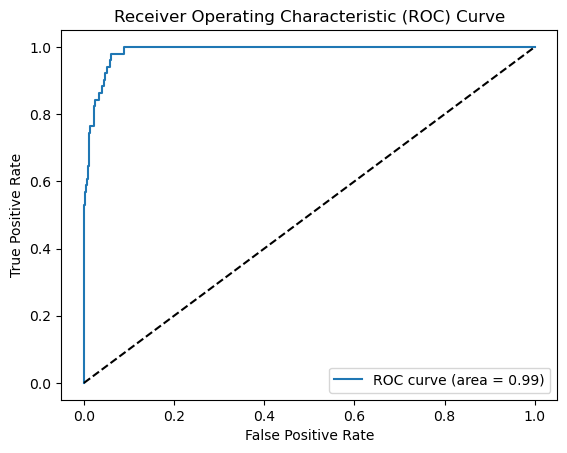

In [46]:
print("AdaBase using all features")
performance_ada_data = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_train_pred_ada),
                                         precision_score(y_train, y_train_pred_ada, pos_label=1),
                                         recall_score(y_train, y_train_pred_ada, pos_label=1)],
                               'Test': [accuracy_score(y_test, y_test_pred_ada),
                                        precision_score(y_test, y_test_pred_ada, pos_label=1),
                                        recall_score(y_test, y_test_pred_ada, pos_label=1)]})

display(performance_ada_data)

from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
probs_ada = ada.predict_proba(X_test_scaled)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, probs_ada)

# Compute the Area Under the Curve (AUC)
roc_auc_ada = auc(fpr_ada, tpr_ada)

# Plot the ROC curve
plt.plot(fpr_ada, tpr_ada, label='ROC curve (area = %0.2f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

/Users/jon/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/jon/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


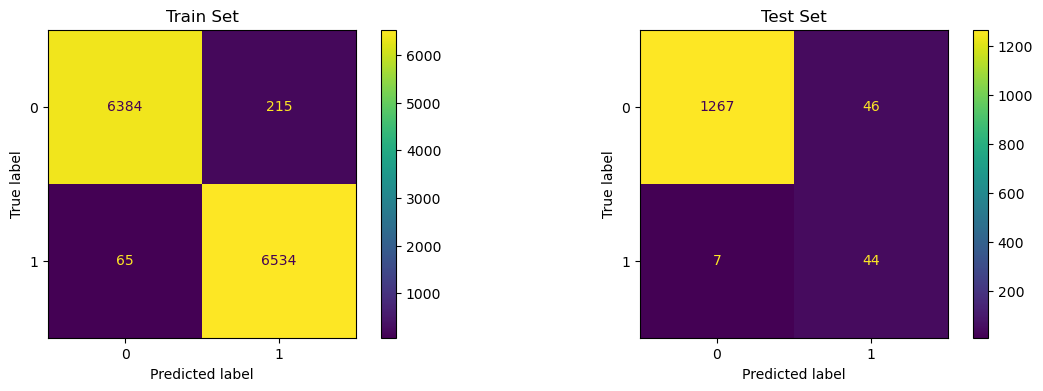

In [50]:
from sklearn.metrics import plot_confusion_matrix


fig, ax = plt.subplots(1,2, figsize=(14,4))

plot_confusion_matrix(ada,X_train_scaled,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

plot_confusion_matrix(ada,X_test_scaled,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

In [108]:
# The AdaBoost model predicts 98.3% of the training dataset correctly. It also shows a big improvement in the test dataset compared to the decision tree model. I would say that the AdaBoost classifier reduces the model bias.

In [51]:
#Feature importance for AdaBoost 
'''
In an AdaBoost model, feature importances can be calculated by computing the total weighted sum of the feature importance scores across all the weak learners in the ensemble. 
Each weak learner in AdaBoost is trained on a subset of the training data and assigns weights to each feature based on their importance in classifying the samples correctly.
'''
importances_ada = ada.feature_importances_
#Another way to get them: feature_importances = np.mean([tree.feature_importances_ for tree in ada.estimators_], axis=0)

#Rank them
indices = np.argsort(importances_ada)[::-1]

print("Feature importances:")
for i in range(X.shape[1]):
    print("%d. feature %d (%f)" % (i + 1, indices[i], importances_ada[indices[i]]))


Feature importances:
1. feature 34 (0.038000)
2. feature 72 (0.038000)
3. feature 8 (0.032000)
4. feature 87 (0.032000)
5. feature 85 (0.030000)
6. feature 39 (0.030000)
7. feature 38 (0.030000)
8. feature 47 (0.028000)
9. feature 53 (0.028000)
10. feature 66 (0.026000)
11. feature 50 (0.026000)
12. feature 9 (0.024000)
13. feature 69 (0.024000)
14. feature 73 (0.024000)
15. feature 37 (0.024000)
16. feature 18 (0.022000)
17. feature 83 (0.020000)
18. feature 43 (0.020000)
19. feature 71 (0.020000)
20. feature 27 (0.018000)
21. feature 67 (0.018000)
22. feature 90 (0.018000)
23. feature 55 (0.016000)
24. feature 46 (0.016000)
25. feature 11 (0.016000)
26. feature 78 (0.016000)
27. feature 79 (0.016000)
28. feature 89 (0.014000)
29. feature 68 (0.014000)
30. feature 14 (0.014000)
31. feature 57 (0.014000)
32. feature 15 (0.012000)
33. feature 48 (0.012000)
34. feature 77 (0.012000)
35. feature 70 (0.012000)
36. feature 24 (0.012000)
37. feature 26 (0.012000)
38. feature 30 (0.012000)
39

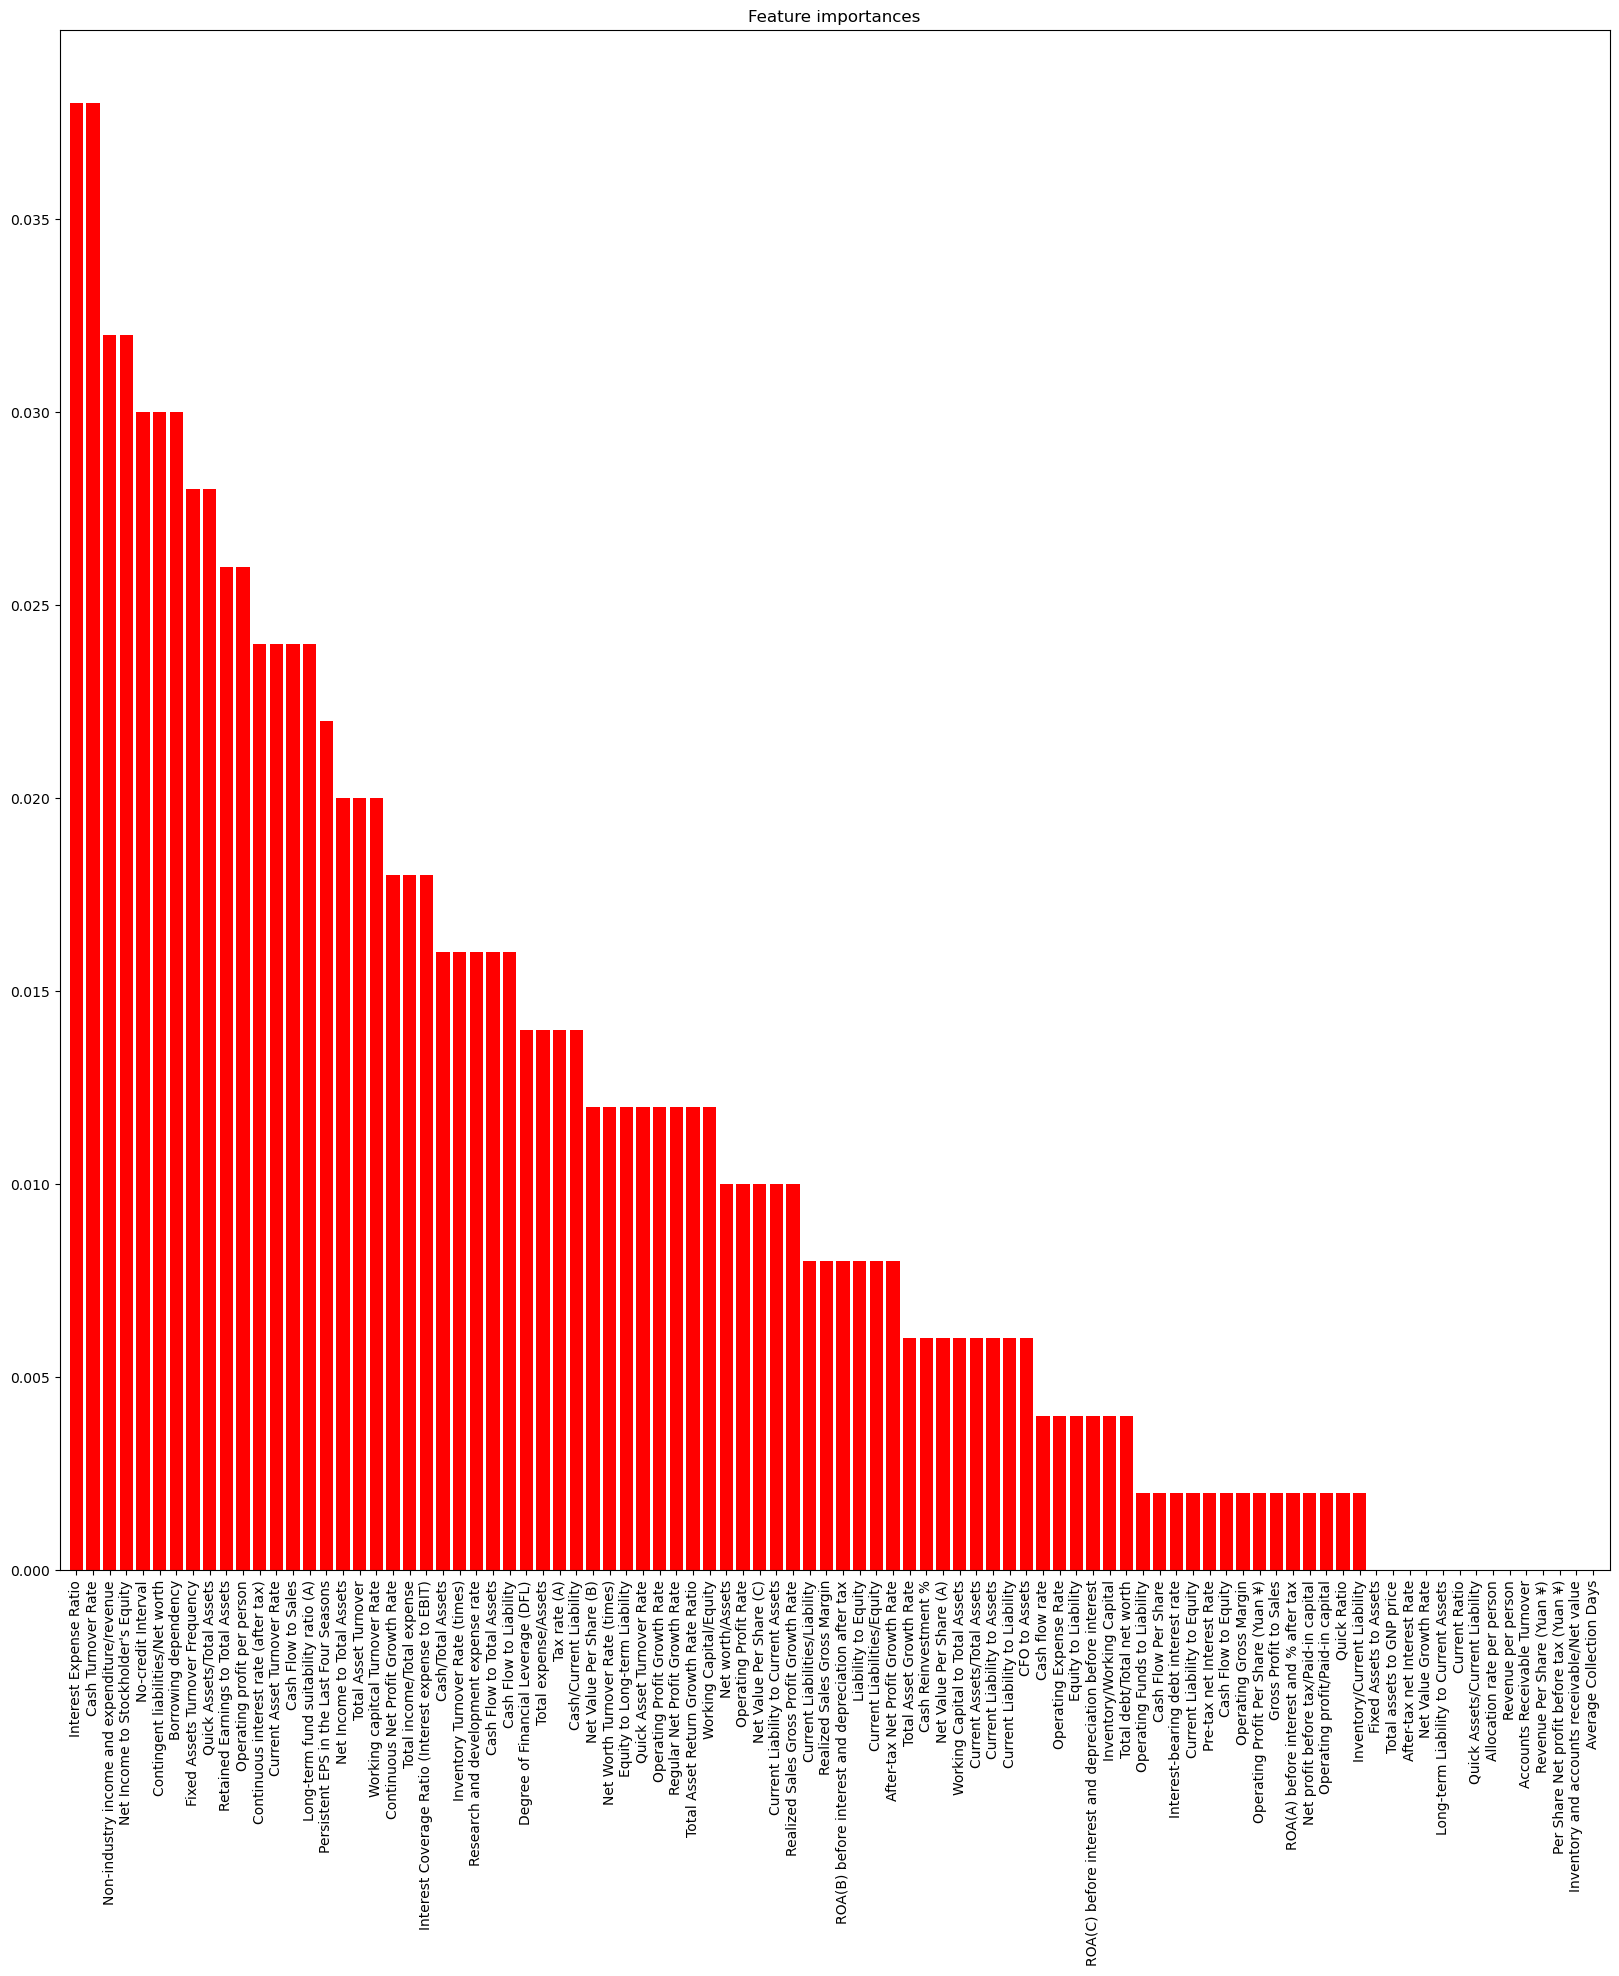

In [52]:
import matplotlib.pyplot as plt

# Create a bar plot of feature importances
feature_names = X.columns

plt.figure(figsize=(20, 20))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances_ada[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [53]:
important_indicies = indices[0:79]
X_important = pd.DataFrame(X[[X.columns[i] for i in important_indicies]])

In [55]:
def feature_iteration(X_train,X_test, y_train, y_test, coefs):
    features_df = pd.DataFrame(importances_ada, index=X.columns.tolist())
    performance_log_n = {'Error_metric': ['Accuracy','Precision','Recall']}
    for n in range(10,len(importances_ada),10):
        # define n features
        features=features_df.nlargest(n,[0]).index.to_list()
        X_train_n=X_train[features]
        X_test_n=X_test[features]
        #Scale and fit data
        scaler= StandardScaler()
        scaler.fit(X_train_n)
        X_train_scale=scaler.transform(X_train_n)
        X_test_scale=scaler.transform(X_test_n)
        #Model
        tree = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=42)
        tree = tree.fit(X_train_scale, y_train)
        ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.5, random_state=42)

        # as only 2 outcomes for target, the transforamtion returns one single columns
        ada.fit(X_train_scale, y_train)
        y_pred_train = ada.predict(X_train_scale)
        y_pred_test = ada.predict(X_test_scale)
        performance_log_n['Test_'+str(n)]=[accuracy_score(y_test, y_pred_test),
                                                precision_score(y_test, y_pred_test),
                                                recall_score(y_test, y_pred_test)]
        #print(f'no. of features {n} {performance_log_n}')
    return pd.DataFrame(performance_log_n)

feature_iteration(X_train,X_test, y_train, y_test, importances_ada[0])

,Error_metric,Test_10,Test_20,Test_30,Test_40,Test_50,Test_60,Test_70,Test_80,Test_90
0,Accuracy,0.932551,0.944282,0.956012,0.960411,0.960411,0.961144,0.964076,0.961144,0.961144
1,Precision,0.330579,0.391304,0.454545,0.483516,0.482759,0.488889,0.511628,0.488889,0.488889
2,Recall,0.784314,0.882353,0.882353,0.862745,0.823529,0.862745,0.862745,0.862745,0.862745


<AxesSubplot:>

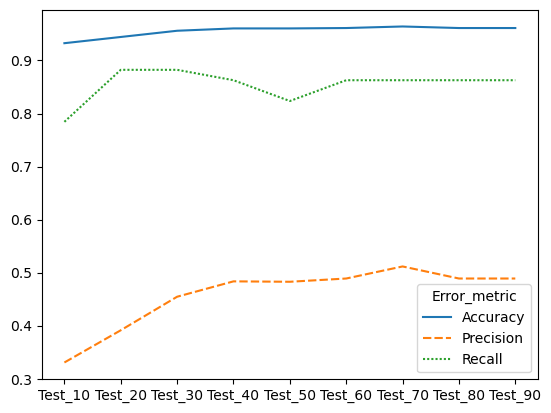

In [56]:
# call function, and name df
df_by_features=feature_iteration(X_train,X_test, y_train, y_test, importances_ada[0])
df_by_features.set_index('Error_metric',inplace=True)
# plot transposed df
sns.lineplot(data=df_by_features.transpose() )

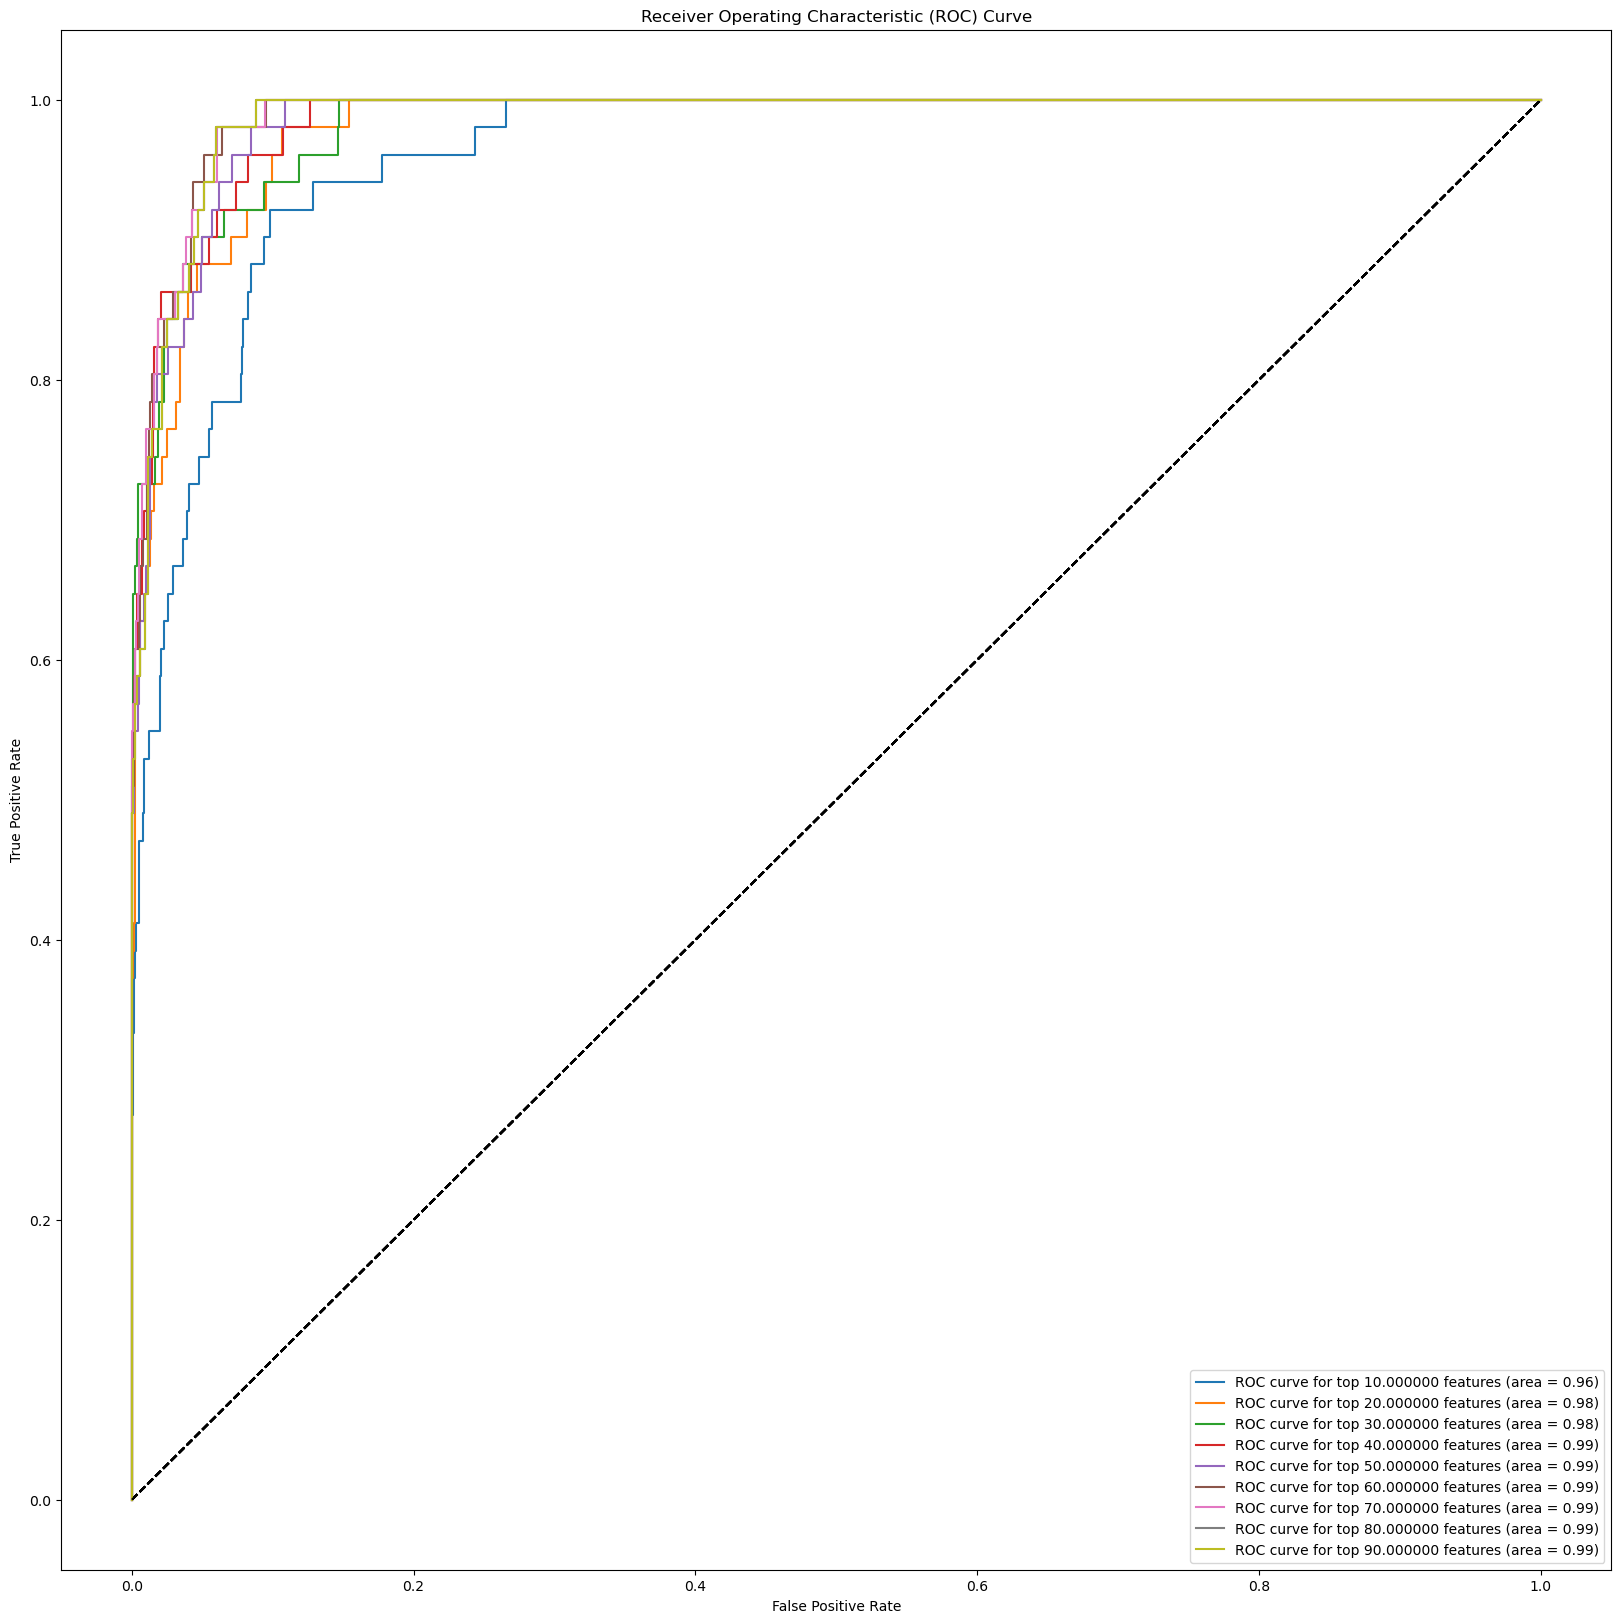

In [58]:
def feature_roc(X_train,X_test, y_train, y_test, coefs):
    features_df = pd.DataFrame(importances_ada, index=X.columns.tolist())
    performance_log_n = {'Error_metric': ['Accuracy','Precision','Recall']}
    plt.figure(figsize=(20, 20))
    for n in range(10,len(importances_ada),10):
        # define n features
        features=features_df.nlargest(n,[0]).index.to_list()
        X_train_n=X_train[features]
        X_test_n=X_test[features]
        #Scale and fit data
        scaler= StandardScaler()
        scaler.fit(X_train_n)
        X_train_scale=scaler.transform(X_train_n)
        X_test_scale=scaler.transform(X_test_n)
        #Model
        tree = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=42)
        tree = tree.fit(X_train_scale, y_train)
        ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.5, random_state=42)

        # Plot roc curves
        ada.fit(X_train_scale, y_train)
        probs_ada = ada.predict_proba(X_test_scale)[:, 1]
        fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, probs_ada)
        roc_auc_ada = auc(fpr_ada, tpr_ada)
        plt.plot(fpr_ada, tpr_ada, label='ROC curve for top %f features (area = %0.2f)' %(n, roc_auc_ada))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

    return plt.show()

feature_roc(X_train,X_test, y_train, y_test, importances_ada[0])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the pipeline to scale the data before fitting the model
pipeline = Pipeline([('scaler', StandardScaler()), ('ada', ada)])

# Define the parameter grid to search over
param_grid = {
    'ada__n_estimators': [100, 500, 1000],
    'ada__learning_rate': [0.1, 0.5, 1],
    'ada__base_estimator__max_depth': [1, 2, 3],
}

# Define the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train_scaled[:, :10], y_train) # using only the first 10 features for the example

# Print the best parameters found by the grid search
print("Best parameters found by grid search:")
print(grid_search.best_params_)
